In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from CRR import MimoConformalRidgeRegressor
from copy import deepcopy

rnd_gen = np.random.default_rng(2024)

In [2]:
num_test_steps = 24 * 7 * 5

fh = 5

url_file = (
    "https://raw.githubusercontent.com/scikit-learn-contrib/MAPIE/master/"
    "examples/data/demand_temperature.csv"
)
demand_df = pd.read_csv(
    url_file, parse_dates=True, index_col=0
)
# demand_df['Demand'] = (demand_df.Demand - demand_df.Demand.min()) / (demand_df.Demand.max() - demand_df.Demand.min()) # Min/max scale
demand_df["Date"] = pd.to_datetime(demand_df.index)
demand_df["Weekofyear"] = demand_df.Date.dt.isocalendar().week.astype("int64")
demand_df["Weekday"] = demand_df.Date.dt.isocalendar().day.astype("int64")
demand_df["Hour"] = demand_df.index.hour
n_lags = 24
for hour in range(1, n_lags):
    demand_df[f"Lag_{hour}"] = demand_df["Demand"].shift(hour)
for hour in range(1, fh):
    demand_df[f"Pre_{hour}"] = demand_df["Demand"].shift(-hour)
    # Comment out below to skip tempereature "forecast"
    # demand_df[f"TempForecast_{hour}"] = demand_df["Demand"].shift(-hour) + rnd_gen.normal(0, 3)
demand_df = demand_df.dropna()
demand_train = demand_df.iloc[:-num_test_steps, :].copy()
demand_test = demand_df.iloc[-num_test_steps:, :].copy()
features = ["Weekofyear", "Weekday", "Hour", "Temperature"]
features += [f"Lag_{hour}" for hour in range(1, n_lags)]
# features += [f"TempForecast_{hour}" for hour in range(1, fh)]
targets = ['Demand']
targets += [f"Pre_{hour}" for hour in range(1, fh)]

X_train = demand_train.loc[
    ~np.any(demand_train[features].isnull(), axis=1), features
]
y_train = demand_train.loc[X_train.index, targets]
X_test = demand_test.loc[:, features]
y_test = demand_test[targets]

X = demand_df[features]
y = demand_df[targets]

initial_window_size = y_train.shape[0]
initial_training_size = int(X.shape[0]//2)
index = y.index[initial_training_size:]

X = X.values
y = y.values#.flatten()

# X = demand_df.Temp.values.reshape(-1,1)
# y = demand_df.y.values

# demand_df.corr()



X_train = X[:initial_training_size]
y_train = y[:initial_training_size]

X_run = X[initial_training_size:]
y_run = y[initial_training_size:]

# Run protocol

In [3]:
h = fh
epsilon = np.array([
                    0.1, 
                    0.15, 
                    0.2, 
                    0.25, 
                    0.3,
                    ])

# epsilon = np.array(fh*[0.1])

gamma = np.array([
                    0.005, 
                    0.007, 
                    0.009, 
                    0.011, 
                    0.013,
                    ])

gamma = np.array(fh*[0])

eps = deepcopy(epsilon) # Control input for ACI

# Initialize memory
err = deepcopy(epsilon) # Initialise error vector at fixed point of ACI iteration
pred_u = np.inf * np.ones((h,h))
pred_l = -np.inf * np.ones((h,h))

# Might make sense to preallocate
ls_uppers = []
ls_lowers = []
ls_trues = []
ls_controls = [eps]

In [4]:
cp = MimoConformalRidgeRegressor(h=fh)

cp.learn_initial_training_set(X_train[:-1], y_train[:-1])

Err = np.zeros(fh) # Record error at each hour

for i, (obj, label) in enumerate(zip(X_run, y_run)):
    # Reality presents the object x
    x = obj
    # Forecaster outputs Gamma
    Gamma = cp.predict(x, epsilon=eps, bounds='both')
    width = cp.width(Gamma)

    l_t, u_t = Gamma[0], Gamma[1]

    # Reality presents the label (which is just the first element)

    y_t = label[0]
    pred_u = np.vstack([u_t, pred_u])[:-1]
    pred_l = np.vstack([l_t, pred_l])[:-1]

    err_t = (y_t > np.diag(pred_u)).astype(int) + (y_t < np.diag(pred_l)).astype(int)  # err_{t,1}
    err[:i] = err_t[:i]

    eps = eps + gamma * (epsilon - err) # ACI step

    cp.learn_one(x, label) 
    err = cp.err(Gamma, label) # This is not realistic. We have to wait to get the true labels. 
    Err += err

    # Save stuff
    ls_lowers.append(l_t)
    ls_uppers.append(u_t)
    ls_trues.append(label)
    ls_controls.append(eps)

In [5]:
L = np.array(ls_lowers)
U = np.array(ls_uppers)

Y = np.array(ls_trues)

Err = (Y < L).astype(int) + (Y > U).astype(int)
Err.mean(axis=0)

array([0.12898331, 0.14719272, 0.19423369, 0.24886191, 0.29135053])

# Plot stuff

In [6]:
df_trues = pd.DataFrame(data=np.array(ls_trues), index=index, columns=[f'y{i+1}' for i in range(h)])
df_uppers = pd.DataFrame(data=U, index=index, columns=[f'u{i+1}' for i in range(h)])
df_lowers = pd.DataFrame(data=L, index=index, columns=[f'l{i+1}' for i in range(h)])

df_err = pd.DataFrame(data=Err, index=index, columns=[f'err{i+1}' for i in range(h)])
df_control = pd.DataFrame(data=np.array(ls_controls[:-1]), index=index, columns=[f'control{i+1}' for i in range(h)])
df_result = pd.concat([df_trues, df_uppers, df_lowers, df_control, df_err], axis='columns')

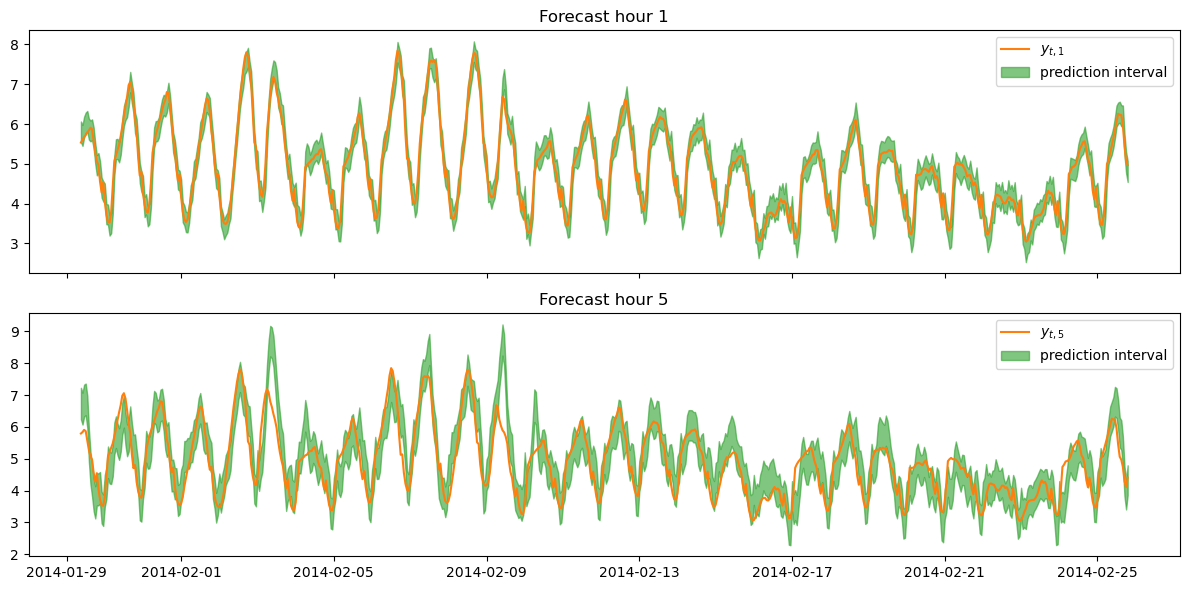

In [7]:
rows = 2
fig, ax = plt.subplots(nrows=rows, figsize=(12,6), sharex=True)
hour = 1
for i, hour in enumerate([1,5]):
    ax[i].plot(df_result[f'y{hour}'], color='C1')
    ax[i].fill_between(
        df_result[f'y{hour}'].index,
        df_result[f'l{hour}'],
        df_result[f'u{hour}'],
        color='C2',
        alpha=0.6
        )
    ax[i].set_title(f'Forecast hour {hour}')
ax[0].legend([r'$y_{t,1}$', 'prediction interval'])
# ax[2].legend([r'$y_{t,2}$', 'prediction interval'])
# ax[2].legend([r'$y_{t,3}$', 'prediction interval'])
# ax[3].legend([r'$y_{t,4}$', 'prediction interval'])
ax[1].legend([r'$y_{t,5}$', 'prediction interval'])
fig.tight_layout()
fig.savefig('plot_diff_eps_diff_gam.png')

Text(0.5, 1.0, 'Forecast hour 1')

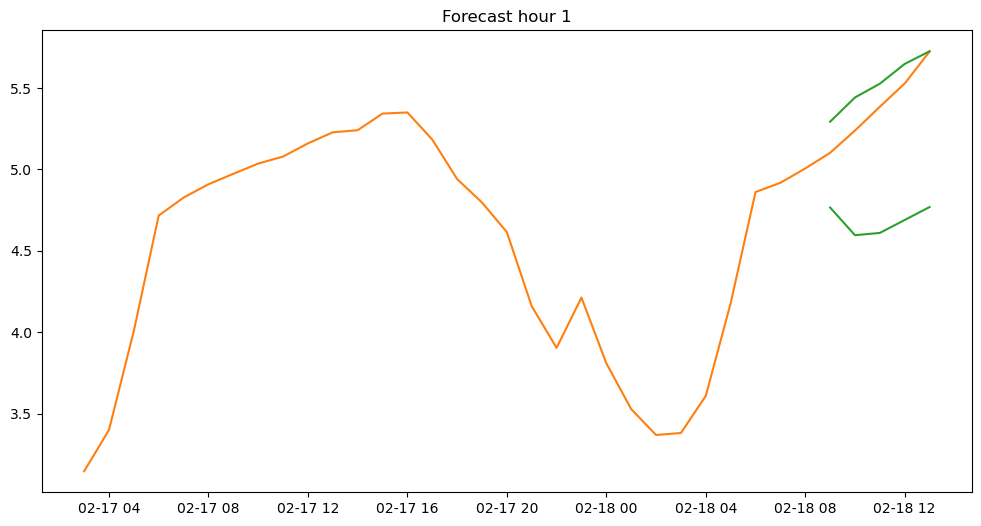

In [8]:
rows = 1
fig, ax = plt.subplots(nrows=rows, figsize=(12,6), sharex=True)
hour = 1

hour_start = 450
pred_start = 480
hour_end = pred_start + 5

ax.plot(df_result[f'y{hour}'][hour_start:hour_end], color='C1')
# ax.fill_between(
#     df_result[f'y{hour}'].index,
#     df_result[f'l{hour}'],
#     df_result[f'u{hour}'],
#     color='C2',
#     alpha=0.6
#     )

df_l = df_result[pred_start:pred_start + 1][[f'l{i}' for i in range(1, 6)]]
df_u = df_result[pred_start:pred_start + 1][[f'u{i}' for i in range(1, 6)]]
ax.plot(pd.DataFrame(data=df_l.values.T, index=pd.date_range(df_l.index[0], periods=5, freq='h'), columns=['Pred']), color='C2')
ax.plot(pd.DataFrame(data=df_u.values.T, index=pd.date_range(df_u.index[0], periods=5, freq='h'), columns=['Pred']), color='C2')


ax.set_title(f'Forecast hour {hour}')